In [321]:
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.contingency import association

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.width", 120)

In [322]:
data_dir_proc = 'data/processed'
clinical = pd.read_csv(Path(data_dir_proc) / 'clinical.tsv', sep='\t', index_col=0)

# describe columns

In [323]:
# get categorical columns
clinical_cat = clinical.select_dtypes(include=['object', 'category', 'bool'])
print(clinical_cat.shape)

(506, 61)


In [324]:
_ = clinical_cat.describe().T
_ = _.rename(columns={'unique': 'n_unique', 'top': 'mode', 'freq': 'n_mode'})
_['n_na'] = clinical.shape[0] - _['count'] # number of missing values
_['p_na'] = _['n_na'] / clinical.shape[0] # proportion of missing values
_['p_mode'] = _['n_mode'] / clinical.shape[0] # proportion of mode values
_ = _.sort_values(['p_na', 'n_unique'])
with pd.option_context('display.max_rows', 100):
    print(_[['n_unique', 'p_na', 'p_mode']])

                                                   n_unique      p_na    p_mode
_cohort                                                   1       0.0       1.0
_primary_disease                                          1       0.0       1.0
_primary_site                                             1       0.0       1.0
tumor_tissue_site                                         1       0.0       1.0
gender                                                    2       0.0  0.535573
history_of_neoadjuvant_treatment                          2       0.0  0.994071
other_dx                                                  4       0.0  0.822134
icd_o_3_site                                              6       0.0   0.58498
icd_10                                                    7       0.0  0.598814
pathologic_T                                              9       0.0  0.320158
histological_type                                        12       0.0  0.616601
icd_o_3_histology                       

# drop columns

In [325]:
# drop clinical columns based on the above results
max_p_na = 0.2
max_p_mode = 0.95

mask = (_['p_na'] <= max_p_na) & (_['p_mode'] <= max_p_mode)
cols_to_keep = _.index[mask]
clinical_cat = clinical_cat.loc[:, clinical_cat.columns.isin(cols_to_keep)]
pprint(clinical_cat.columns.to_list())

['anatomic_neoplasm_subdivision',
 'gender',
 'histological_type',
 'icd_10',
 'icd_o_3_histology',
 'icd_o_3_site',
 'other_dx',
 'pathologic_M',
 'pathologic_N',
 'pathologic_T',
 'pathologic_stage',
 'person_neoplasm_cancer_status',
 'primary_therapy_outcome_success',
 'radiation_therapy',
 'targeted_molecular_therapy']


# inspect remaining columns

In [326]:
with pd.option_context('display.max_rows', 100):
    for col in clinical_cat:
        print()
        print(clinical_cat[col].value_counts(dropna=False))


anatomic_neoplasm_subdivision
R-Upper                   179
L-Upper                   119
R-Lower                    96
L-Lower                    77
R-Middle                   23
[Discrepancy]               5
Other (please specify)      4
NaN                         3
Name: count, dtype: int64

gender
FEMALE    271
MALE      235
Name: count, dtype: int64

histological_type
Lung Adenocarcinoma- Not Otherwise Specified (NOS)    312
Lung Adenocarcinoma Mixed Subtype                     107
Lung Papillary Adenocarcinoma                          22
Lung Bronchioloalveolar Carcinoma Nonmucinous          19
Lung Acinar Adenocarcinoma                             18
Mucinous (Colloid) Carcinoma                           10
Lung Solid Pattern Predominant Adenocarcinoma           5
Lung Bronchioloalveolar Carcinoma Mucinous              5
Lung Micropapillary Adenocarcinoma                      3
Lung Clear Cell Adenocarcinoma                          2
Lung Mucinous Adenocarcinoma              

# colinearity

In [327]:
cramersv = []
for col1 in clinical_cat:
    for col2 in clinical_cat:
        if col1 <= col2:
            continue
        ctab = pd.crosstab(clinical_cat[col1], clinical_cat[col2], dropna=False)
        cramersv.append({
            'col1': col1,
            'col2': col2,
            'df1': ctab.shape[0],
            'df2': ctab.shape[1],
            'size': ctab.shape[0] * ctab.shape[1],
            'cramersv': association(ctab, method='cramer') # bounded by (0, 1)
        })
cramersv = pd.DataFrame(cramersv)
cramersv = cramersv.sort_values('cramersv', ascending=False).reset_index(drop=True)
print(cramersv.head(20))


                               col1                             col2  df1  df2  size  cramersv
0                      icd_o_3_site                           icd_10    6    7    42  0.938833
1                 icd_o_3_histology                histological_type   12   12   144  0.894092
2                  pathologic_stage                     pathologic_N   11    6    66  0.706409
3        targeted_molecular_therapy                radiation_therapy    3    3     9  0.703124
4                      icd_o_3_site    anatomic_neoplasm_subdivision    6    8    48  0.649884
5                            icd_10    anatomic_neoplasm_subdivision    7    8    56  0.603911
6                  pathologic_stage                     pathologic_M   11    6    66  0.496063
7                  pathologic_stage                     pathologic_T   11    9    99  0.492383
8                 radiation_therapy  primary_therapy_outcome_success    3    6    18  0.487036
9        targeted_molecular_therapy  primary_thera

In [328]:
def side_by_side_plot(col1, col2, figsize=(10, 4)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    clinical_cat[col1].value_counts(dropna=False).rename(col1).plot(kind='bar', ax=axes[0], subplots=True)
    clinical_cat[col2].value_counts(dropna=False).rename(col2).plot(kind='bar', ax=axes[1], subplots=True)
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')

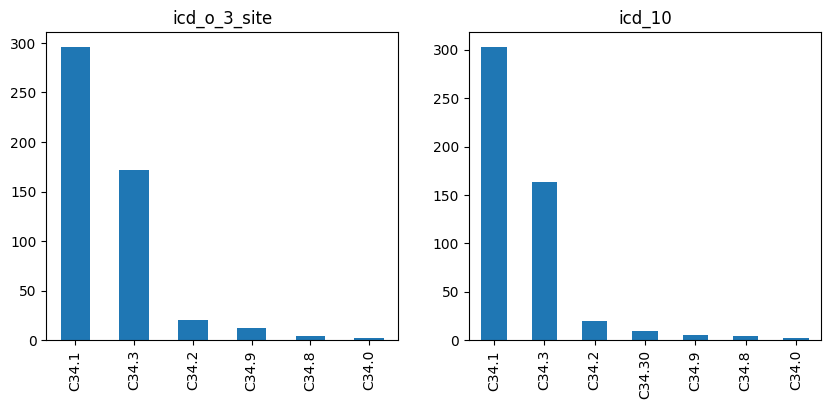

In [329]:
side_by_side_plot('icd_o_3_site', 'icd_10')
# drop icd_10 since it has a typo (C34.30 should be C34.3)
# merge rare classes for icd_o_3_site

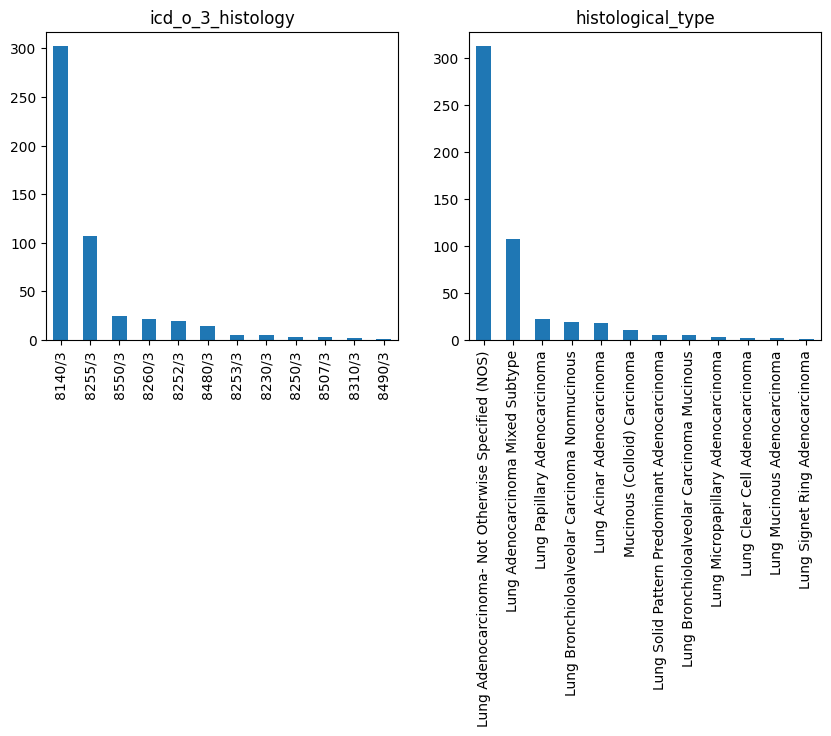

In [330]:
side_by_side_plot('icd_o_3_histology', 'histological_type')
# drop histological_type since icd_o_3_histology is more standardised re external datasets
# merge rare classes for icd_o_3_histology

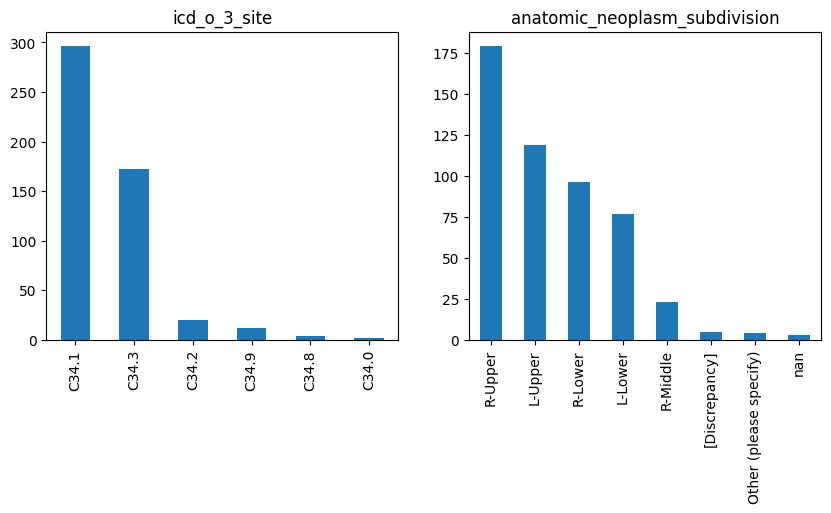

In [331]:
side_by_side_plot('icd_o_3_site', 'anatomic_neoplasm_subdivision')
# drop anatomic_neoplasm_subdivision since it has some missing values and has higher cardinality

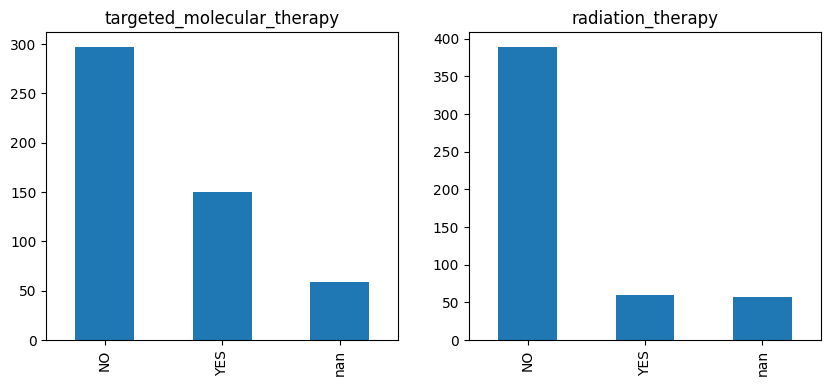

In [332]:
side_by_side_plot('targeted_molecular_therapy', 'radiation_therapy')
# keep both asis

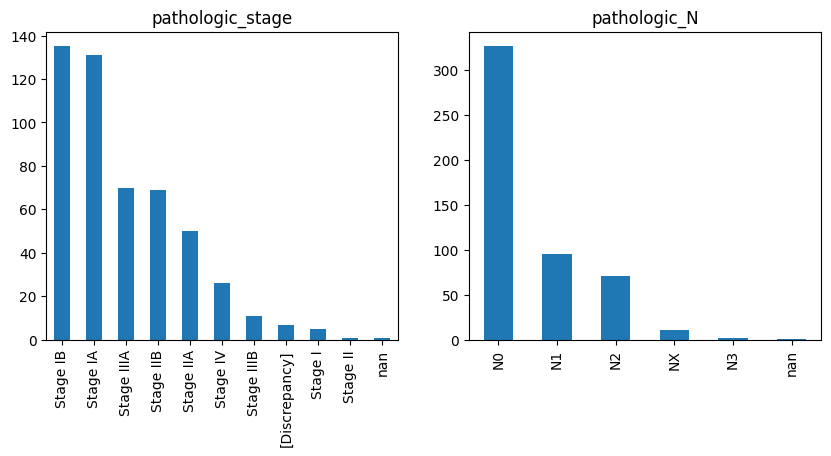

In [333]:
side_by_side_plot('pathologic_stage', 'pathologic_N')
# keep pathologic_stage but merge classes
# keep pathologic_N but merge non-NO classes (N0 = No lymph node involvement)

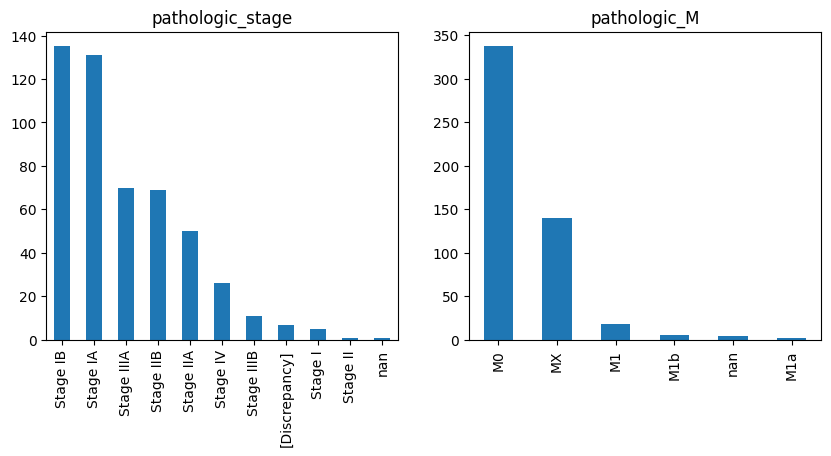

In [334]:
side_by_side_plot('pathologic_stage', 'pathologic_M')
# keep pathologic_stage but merge classes
# keep pathologic_M but merge non-MO classes (M0 = No distant metastasis)

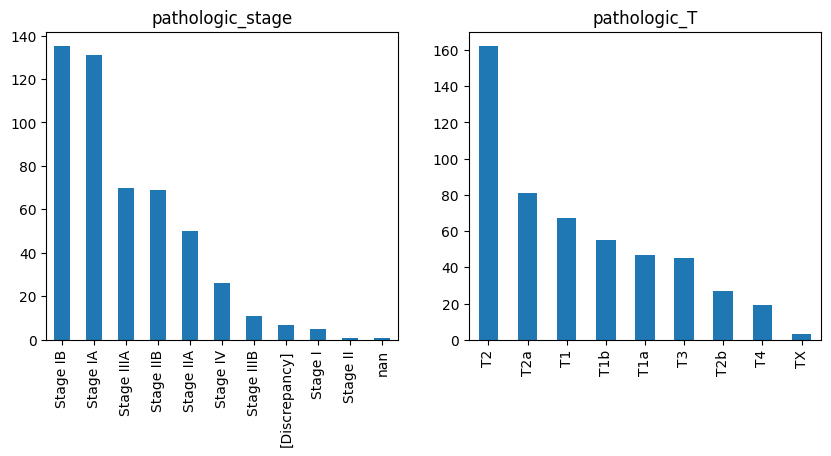

In [335]:
side_by_side_plot('pathologic_stage', 'pathologic_T')

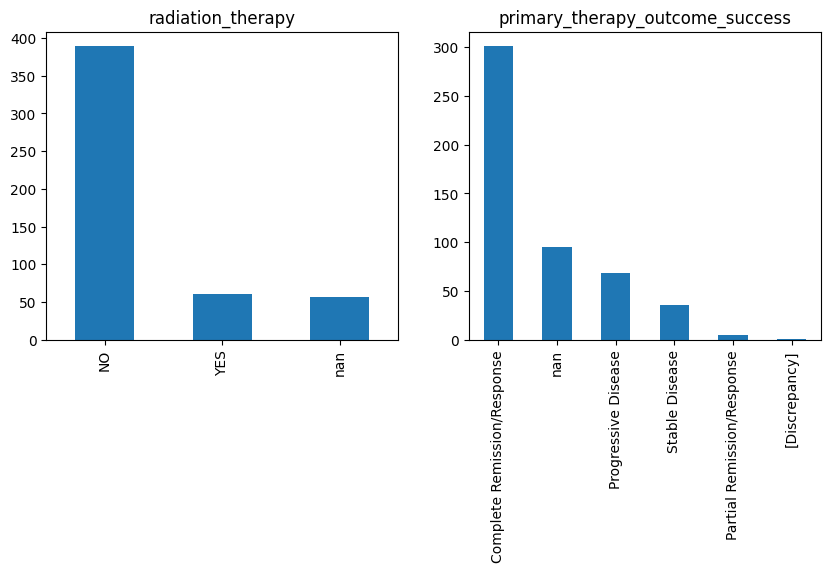

In [336]:
side_by_side_plot('radiation_therapy', 'primary_therapy_outcome_success')
# merge primary_therapy_outcome_success classes

In [337]:
clinical_cat['primary_therapy_outcome_success'].value_counts(dropna=False)

primary_therapy_outcome_success
Complete Remission/Response    301
NaN                             95
Progressive Disease             68
Stable Disease                  36
Partial Remission/Response       5
[Discrepancy]                    1
Name: count, dtype: int64

In [338]:
cols_to_drop = [
    'icd_10', 
    'histological_type', 
    'anatomic_neoplasm_subdivision',
]

clinical_cat = clinical_cat.loc[:, ~clinical_cat.columns.isin(cols_to_drop)]
print(clinical_cat.shape)

(506, 12)


# feature engineering

I.e. merge classes to reduce dimensionality and to combine rare classes.

In [339]:
col = 'other_dx'
clinical_cat[col] = clinical_cat[col]\
    .replace("Yes, History of Prior Malignancy", "Yes")\
    .replace("Yes, History of Synchronous/Bilateral Malignancy", "Yes")
clinical_cat[col].value_counts(dropna=False)    

other_dx
No     416
Yes     90
Name: count, dtype: int64

In [340]:
col = 'icd_o_3_site'
clinical_cat[col] = clinical_cat[col]\
    .replace("C34.2", "~OTHER")\
    .replace("C34.9", "~OTHER")\
    .replace("C34.8", "~OTHER")\
    .replace("C34.0", "~OTHER")
clinical_cat[col].value_counts(dropna=False)    

icd_o_3_site
C34.1     296
C34.3     172
~OTHER     38
Name: count, dtype: int64

In [341]:
col = 'icd_o_3_histology'
clinical_cat[col] = clinical_cat[col]\
    .replace("8550/3", "~OTHER")\
    .replace("8260/3", "~OTHER")\
    .replace("8252/3", "~OTHER")\
    .replace("8480/3", "~OTHER")\
    .replace("8253/3", "~OTHER")\
    .replace("8230/3", "~OTHER")\
    .replace("8250/3", "~OTHER")\
    .replace("8507/3", "~OTHER")\
    .replace("8310/3", "~OTHER")\
    .replace("8490/3", "~OTHER")
clinical_cat[col].value_counts(dropna=False) 

icd_o_3_histology
8140/3    302
8255/3    107
~OTHER     97
Name: count, dtype: int64

In [342]:
col = 'person_neoplasm_cancer_status'
clinical_cat[col] = clinical_cat[col]\
    .replace("WITH TUMOR", '~OTHER')\
    .replace("[Discrepancy]", '~OTHER')
clinical_cat[col].value_counts(dropna=False)    

person_neoplasm_cancer_status
TUMOR FREE    289
~OTHER        165
NaN            52
Name: count, dtype: int64

In [343]:
# primary tumour
col = 'pathologic_T'
clinical_cat[col] = clinical_cat[col]\
    .replace("T1a", "T1")\
    .replace("T1b", "T1")\
    .replace("T2a", "T2")\
    .replace("T2b", "T2")\
    .replace("T3", "~OTHER")\
    .replace("T4", "~OTHER")\
    .replace("TX", '~OTHER')
clinical_cat[col].value_counts(dropna=False)    

pathologic_T
T2        270
T1        169
~OTHER     67
Name: count, dtype: int64

In [344]:
# lymph nodes
col = 'pathologic_N'
clinical_cat[col] = clinical_cat[col]\
    .replace("N1", "~OTHER")\
    .replace("N2", "~OTHER")\
    .replace("N3", "~OTHER")\
    .replace("NX", '~OTHER')
clinical_cat[col].value_counts(dropna=False)    

pathologic_N
N0        326
~OTHER    179
NaN         1
Name: count, dtype: int64

In [345]:
# metastasis
col = 'pathologic_M'
clinical_cat[col] = clinical_cat[col]\
    .replace("M1", "~OTHER")\
    .replace("M1a", "~OTHER")\
    .replace("M1b", "~OTHER")\
    .replace("MX", '~OTHER')
clinical_cat[col].value_counts(dropna=False)    

pathologic_M
M0        337
~OTHER    165
NaN         4
Name: count, dtype: int64

In [346]:
col = 'pathologic_stage'
clinical_cat[col] = clinical_cat[col]\
    .replace("Stage IA", "Stage I")\
    .replace("Stage IB", "Stage I")\
    .replace("Stage IIA", "Stage II")\
    .replace("Stage IIB", "Stage II")\
    .replace("Stage IIIA", "~OTHER")\
    .replace("Stage IIIB", "~OTHER")\
    .replace("Stage IV", "~OTHER")\
    .replace("[Discrepancy]", "~OTHER")
clinical_cat[col].value_counts(dropna=False)    

pathologic_stage
Stage I     271
Stage II    120
~OTHER      114
NaN           1
Name: count, dtype: int64

In [347]:
col = 'primary_therapy_outcome_success'
clinical_cat[col] = clinical_cat[col]\
    .replace("Complete Remission/Response", "Complete/Partial Remission/Response")\
    .replace("Partial Remission/Response", "Complete/Partial Remission/Response")\
    .replace("Progressive Disease", "Progressive/Stable Disease")\
    .replace("Stable Disease", "Progressive/Stable Disease")\
    .replace("[Discrepancy]", "~OTHER")
clinical_cat[col].value_counts(dropna=False)    

primary_therapy_outcome_success
Complete/Partial Remission/Response    306
Progressive/Stable Disease             104
NaN                                     95
~OTHER                                   1
Name: count, dtype: int64

# re-inspect columns

In [348]:
with pd.option_context('display.max_rows', 100):
    for col in clinical_cat:
        print()
        print(clinical_cat[col].value_counts(dropna=False))


gender
FEMALE    271
MALE      235
Name: count, dtype: int64

icd_o_3_histology
8140/3    302
8255/3    107
~OTHER     97
Name: count, dtype: int64

icd_o_3_site
C34.1     296
C34.3     172
~OTHER     38
Name: count, dtype: int64

other_dx
No     416
Yes     90
Name: count, dtype: int64

pathologic_M
M0        337
~OTHER    165
NaN         4
Name: count, dtype: int64

pathologic_N
N0        326
~OTHER    179
NaN         1
Name: count, dtype: int64

pathologic_T
T2        270
T1        169
~OTHER     67
Name: count, dtype: int64

pathologic_stage
Stage I     271
Stage II    120
~OTHER      114
NaN           1
Name: count, dtype: int64

person_neoplasm_cancer_status
TUMOR FREE    289
~OTHER        165
NaN            52
Name: count, dtype: int64

primary_therapy_outcome_success
Complete/Partial Remission/Response    306
Progressive/Stable Disease             104
NaN                                     95
~OTHER                                   1
Name: count, dtype: int64

radiation_ther

# re-check colinearity

In [349]:
cramersv = []
for col1 in clinical_cat:
    for col2 in clinical_cat:
        if col1 <= col2:
            continue
        ctab = pd.crosstab(clinical_cat[col1], clinical_cat[col2], dropna=False)
        cramersv.append({
            'col1': col1,
            'col2': col2,
            'df1': ctab.shape[0],
            'df2': ctab.shape[1],
            'size': ctab.shape[0] * ctab.shape[1],
            'cramersv': association(ctab, method='cramer') # bounded by (0, 1)
        })
cramersv = pd.DataFrame(cramersv)
cramersv = cramersv.sort_values('cramersv', ascending=False).reset_index(drop=True)
print(cramersv.head(20))

                               col1                             col2  df1  df2  size  cramersv
0                  pathologic_stage                     pathologic_N    4    3    12  0.882933
1        targeted_molecular_therapy                radiation_therapy    3    3     9  0.703124
2                 radiation_therapy  primary_therapy_outcome_success    3    4    12  0.485395
3        targeted_molecular_therapy  primary_therapy_outcome_success    3    4    12  0.466639
4   primary_therapy_outcome_success    person_neoplasm_cancer_status    4    3    12  0.453365
5        targeted_molecular_therapy                 pathologic_stage    3    4    12  0.370419
6                  pathologic_stage                     pathologic_M    4    3    12  0.358272
7                  pathologic_stage                     pathologic_T    4    3    12  0.356522
8                      pathologic_N                     pathologic_M    3    3     9  0.355332
9        targeted_molecular_therapy               

# write

In [350]:
clinical_cat.to_csv(Path(data_dir_proc) / 'clinical_cat.tsv', sep='\t')